# CBDC ABM Simulation

This notebook contains a simulation for a toy economy that consists of a number of households, firms, banks and a central bank. Households are employed at firms, are paid wages for labour, produce output and purchase output. Wages are paid and output is paid for using a combination of deposits at banks and Central Bank Digital Currency.

## Configuring the model

The parameter_values below can be specified for different simulations.

In [1]:
import xml.etree.ElementTree as ET

Below you will find the parameter inputs for this model. Change the parameter values for different configurations of the model.

In [2]:
parameter_values = (('num_sweeps', '12'),
                    ('num_simulations', '1'),
                    ('num_households', '40'),
                    ('num_firms', '8'),
                    ('num_banks', '2'),
                    ('num_ach', '1'),
                    ('num_central_bank', '1'),
                    ('batch', '2'),
                    ('reserves_interest', '0.00'),
                    ('loans_central_bank_interest', '0.000118'),
                    ('open_market_operations_interest', '0.000116'),
                    ('loans_interbank_interest', '0.000115'),
                    ('loans_interest', '0.0004'),
                    ('deposits_interest', '0.00008'),
                    ('clearing_house_fee', '0.1'),
                    ('household_directory', 'agents/gen_households/'),
                    ('firm_directory', 'agents/gen_firms/'),
                    ('bank_directory', 'agents/gen_banks/'),
                    ('ach_directory', 'agents/ach/'),
                    ('central_bank_directory', 'agents/central_bank/'),
                    ('measurement_config', 'measurements/test_measurements.xml')
                   )

To translate this to an xml document, which the framework can read, we first need create an ET element. 

In [3]:
environment = ET.Element('environment', identifier = "CBDC_parameters")

And create parameter elements and give them the values seen below to add to the tree object.

In [4]:
parameters = []
for x in range(len(parameter_values)):
    parameters.append(ET.SubElement(environment, 'parameter'))
    
for idx, p in enumerate(parameters):
    p.set('type', 'static')
    p.set('name', parameter_values[idx][0])
    p.set('value', parameter_values[idx][1])

This object can now be transformed to a string and written to an xml file using the code below. 

In [5]:
xml_params = ET.tostring(environment, encoding="UTF-8")
myfile = open("environments/CBDC_parameters.xml", "w")
xml_params = "<?xml version='1.0' encoding='UTF-8'?>\n" + str(xml_params, encoding = "UTF-8")
myfile.write(xml_params)
myfile.close()

Now, the parameter xml file has been generated and the model can be run. Before, running the model, you need to import a couple of extra modules. These are the Python logging module, the Black Rhino environment class, and the Black Rhino runner class.

In [6]:
import logging
import os
from src.environment import Environment
from src.runner import Runner

Then, before running the model, the logger needs to be initialized.

In [7]:
log_directory = "log/"
identifier = "/CBDC_parameters"
environment_directory = "environments/"
if not os.path.exists('log'):
    os.makedirs('log')
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    filename=log_directory + identifier + ".log", level=logging.INFO)
logging.info('START logging for run: %s',  environment_directory + identifier + ".xml")

Generate banks and households using the generate agents class. First remove any agents still in directories. Then generate agents, the number of households and banks needs to be specified. In the generate banks method, the number of banks is the second argument. In the generate households method, the number of households it the second argument and the number of banks is the thrid argument.

In [8]:
import os
remove = True

bank_dir = os.getcwd()+'/agents/gen_banks/'
house_dir = os.getcwd()+'/agents/gen_households/'
firm_dir = os.getcwd()+'/agents/gen_firms/'
if remove:
    bank_list = [ f for f in os.listdir(bank_dir) if f.startswith("bank") ]
    house_list = [ f for f in os.listdir(house_dir) if f.startswith("house") ]
    firm_list = [ f for f in os.listdir(firm_dir) if f.startswith("firm") ]
for f in bank_list:
    os.remove(os.path.join(bank_dir, f))
for f in house_list:
    os.remove(os.path.join(house_dir, f))
for f in firm_list:
    os.remove(os.path.join(firm_dir, f))

In [9]:
from src.br_generate_agents import Generate_Agents
gen_agents = Generate_Agents()

gen_agents.generate_households(parameter_values[2][1], "./agents/gen_households/")

gen_agents.generate_firms(parameter_values[3][1], "./agents/gen_firms/")

gen_agents.generate_banks(parameter_values[4][1], "./agents/gen_banks/")

First, the environment will be initialized. It contains the model parameters and variables. The environment also contains a list of agents. In the Solow model, the environment contains one bank, one firm, and one household. Finally, it also contains initialized transactions for these agents.

In [10]:
environment = Environment(environment_directory, identifier)


Create xml for measurements. First create template, then read in different accounts of interest for different agents, finally read in general variables of interest. NB running the general measurements closes the xml file. 

In [11]:
from src.br_measurements import Generate_Measurements
gen_measurements = Generate_Measurements()

general_accounts = ["total_output", "number_of_deposits", "clearing_house_fee_total"]
gen_measurements.generate_measurements(general_accounts, "./measurements/test_measurements")



Import GDP data for calibration. Data is average GDP per firm per employee over 4000 (The mean of the labour distribution).

In [12]:
# # importing the module
# import json
  
# # Opening JSON file
# with open('gdp.json') as json_file:
#     gdp_calibrate = json.load(json_file)
# environment.gdp_calibrate = gdp_calibrate

Next up, the runner object is created. As the name suggests, the runner object handles the running of the model. But that is not all, it also initializes the updater.

In [13]:
runner = Runner(environment)

Now you can actually run the model. Since the agent-based model is simulated using Monte Carlo methods. This means that the model will be run multiple times (num_simulations). For every simulation run, the environment and runner will be (re-)initialized. Then, the runner will run the Solow model. During the run, the runner will write data about capital to a csv file specified within the Measurement class and print out all the transactions happening and the books of firm and household at the end of each sweep.

In [14]:
for i in range(int(environment.num_simulations)):
    logging.info('  STARTED with run %s',  str(i))
    environment.initialize(environment_directory,  identifier)
    runner.initialize(environment)
    
    runner.do_run(environment)
    logging.info('  DONE')

measurements/test_measurements.xml

 central_bank initialize with 14467.0 reserves

 central_bank initialize with 25777.0 reserves

 RTGS payment of 2007.0 of reserves from bank_1 to central_bank at time 0d.
firm_5 took out loan of 2007.0 for capital

 RTGS payment of 2493.0 of reserves from bank_1 to central_bank at time 0d.
firm_4 took out loan of 2493.0 for capital

 RTGS payment of 1940.0 of reserves from bank_1 to central_bank at time 0d.
firm_6 took out loan of 1940.0 for capital

 RTGS payment of 1398.0 of reserves from bank_1 to central_bank at time 0d.
firm_7 took out loan of 1398.0 for capital

 RTGS payment of 2057.0 of reserves from bank_1 to central_bank at time 0d.
firm_3 took out loan of 2057.0 for capital

 RTGS payment of 2403.0 of reserves from bank_1 to central_bank at time 0d.
firm_2 took out loan of 2403.0 for capital

 RTGS payment of 2467.0 of reserves from bank_1 to central_bank at time 0d.
firm_0 took out loan of 2467.0 for capital

 RTGS payment of 4715.0 of r

In [15]:
environment.number_of_deposits

333

Check to see if all agents balance sheets are consistent. Rounding erros may result in not all agents having consistent balance sheets.

In [16]:
npv = 0.0
wealth = 0.0
for houses in environment.households:
    npv += houses.check_npv()[houses.identifier]["npv"]
    wealth += houses.wealth

print(f"Household NPV is {round(npv, 2)} and wealth is {wealth}")

firm = True
for firms in environment.firms:
    firm *= firms.check_consistency()
if firm:
    print("All firms have consistent balance sheets")
else:
    print("Not all firms have consistent balance sheets")

bank = True
for banks in environment.banks:
    bank *= banks.check_consistency()
if bank:
    print("All banks have consistent balance sheets")
else:
    print("Not all banks have consistent balance sheets")

if environment.ach[0].check_consistency():
    print("ACH has consistent balance sheets")
elif environment.ach[0].check_consistency() is False:
    print("ACH does not consistent balance sheets")

print(f"Central Bank reserves are {environment.central_bank[0].get_account('reserves')}")

# if environment.central_bank[0].check_consistency():
#     print("Central Bank has consistent balance sheets")
# elif environment.central_bank[0].check_consistency() is False:
#     print("Central Bank does not consistent balance sheets")

Household NPV is 40116.3 and wealth is 40244.0
All firms have consistent balance sheets
All banks have consistent balance sheets
ACH has consistent balance sheets
Central Bank reserves are 412.95815870000007


Print Balance Sheet for one randomly selected household, firm and bank, and central bank.

In [17]:
import pandas as pd
from functools import reduce

balance_b = []
for agent in environment.banks:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.rename({"ach_payee_" + agent.identifier : "ach_payee", "ach_payer_" + agent.identifier : "ach_payer"}, inplace=True)
    agent_bal.rename({"loans_interbank_" + agent.identifier : "loans_interbank"}, inplace=True)
    agent_bal.loc['Total'] = round(agent_bal.sum(), 0)
    balance_b.append(agent_bal)

print("Total Bank Balance Sheet")
bank_balance = round(reduce(lambda x, y: x.add(y, fill_value=0), balance_b), 6)
print(bank_balance)

balance_sheet_ach = environment.ach[0].balance_sheet()
ach_bal = pd.DataFrame.from_dict(balance_sheet_ach["ach"], orient="columns")
ach_bal.loc['Total']= round(ach_bal.sum(), 0)
print("ACH Balance Sheet")
print(ach_bal)

balance_f = []
for agent in environment.firms:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.loc['Total']= round(agent_bal.sum(), 0)
    balance_f.append(agent_bal)

print("Total Firm Balance Sheet")
firm_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_f)
print(firm_balance)

balance_h = []
for agent in environment.households:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.loc['Total']= round(agent_bal.sum(), 0)
    balance_h.append(agent_bal)

print("Total Household Balance Sheet")
house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h)
print(house_balance)



balance_sheet_cb = environment.central_bank[0].balance_sheet()
central_bank_bal = pd.DataFrame.from_dict(balance_sheet_cb["central_bank"], orient="columns")
central_bank_bal.loc['Total']= round(central_bank_bal.sum(), 0)
print("Central Bank Balance Sheet")
print(central_bank_bal)

total_balance = central_bank_bal[-1:] + bank_balance[-1:] + firm_balance[-1:] + house_balance[-1:] 
print("Overall Balance Sheet Totals")
print(total_balance)

Total Bank Balance Sheet
                              assets   liabilities
interbank_loans             0.000000           NaN
loans                   19482.792830           NaN
reserves                  412.958159           NaN
bank_notes                  0.000000           NaN
open_market_operations  20341.414563           NaN
ach_payee                  14.620956           NaN
deposits                         NaN  20728.171874
receivables                      NaN     14.620956
loans_central_bank               NaN      0.000000
ach_payer                        NaN     14.620956
loans_interbank                  NaN      0.000000
equity                           NaN  19494.372722
Total                   40252.000000  40252.000000
ACH Balance Sheet
                 assets  liabilities
ach_payer  1.462096e+01          NaN
reserves  -1.554312e-15          NaN
ach_payee           NaN    14.620956
Total      1.500000e+01    15.000000
Total Firm Balance Sheet
                  assets  liabili

In [18]:
import pandas as pd
thesis_data = pd.read_csv('measurements/Test_Output.csv', index_col=0) 

In [19]:
environment.clearing_house_fee_total

9.627277900000001

In [20]:
print(thesis_data.head(3))
print(thesis_data.tail(4))

      total_output  number_of_deposits  clearing_house_fee_total
Step                                                            
1              0.0                   0                  0.000000
2             40.0                  38                  0.000000
3             80.0                  63                  1.432889
      total_output  number_of_deposits  clearing_house_fee_total
Step                                                            
9            320.0                 238                  7.785437
10           360.0                 272                  7.785437
11           400.0                 300                  9.627278
12           440.0                 333                  9.627278


Function to read in json files containing balance sheets and create data frames

In [21]:
def json_to_dataframe_total(df, num_sim):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = [] # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                agent_bal = pd.DataFrame.from_dict(list(k.values())[0], orient="columns") # Create df of balance sheet
                balance_h.append(agent_bal) # Append current agent balance sheet to previous balance sheets


        house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h) # Sum all df together
        house_balance = pd.DataFrame(house_balance.fillna(0).sum(axis=1)) # Replace NA with 0's and sum asset and liabilities side together to made single col
        df_new = pd.concat([df_new, house_balance.T]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

Function to read in json file containing balance sheet and create dataframe of specific account for all agents of certain type over course of simulation 

In [67]:
def json_to_dataframe_account(df, num_sim, account):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = {} # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                for h in k.keys():
                    for v in k[h].values():
                        try:
                            balance_h[h] = v[account]
                            
                        except:
                            pass
        agent_bal = pd.DataFrame([balance_h]) # Create df of balance sheet
        df_new = pd.concat([df_new, agent_bal]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

In [22]:
import pandas as pd
import json

num_sim = int(parameter_values[0][1])

# Households
file_in = str('measurements/household_output.json')
df = json.load(open(file_in))

df_household = json_to_dataframe_total(df, num_sim)

# Firms
file_in = str('measurements/firm_output.json')
df = json.load(open(file_in))

df_firm = json_to_dataframe_total(df, num_sim)

# Bank
file_in = str('measurements/bank_output.json')
df = json.load(open(file_in))

df_bank = json_to_dataframe_total(df, num_sim)
col_names = list(df_bank.columns)
col_names = [x for x in col_names if 'ach_payee' in x]

df_bank['ach_payee'] = df_bank[col_names].sum(axis=1)
df_bank = df_bank.drop(columns = col_names)

col_names = list(df_bank.columns)
col_names = [x for x in col_names if 'ach_payer' in x]

df_bank['ach_payer'] = df_bank[col_names].sum(axis=1)
df_bank = df_bank.drop(columns = col_names)


# ACH 
file_in = str('measurements/ach_output.json')
df = json.load(open(file_in))

df_ach = json_to_dataframe_total(df, num_sim)

# Central Bank
file_in = str('measurements/central_output.json')
df = json.load(open(file_in))

df_central = json_to_dataframe_total(df, num_sim)

print("Households")
print(df_household.head())
print("Firms")
print(df_firm.head())
print("Banks")
print(df_bank.head())
print("Clearing House")
print(df_ach.head())
print("Central Bank")
print(df_central.head())



Households
     deposits  bank_notes  receivables  equity_firm  equity_bank  loans
0  1260.00000         0.0          0.0    19480.000    19504.000    0.0
1  1219.99998         0.0          0.0    19480.000    19504.000    0.0
2  1180.00002         0.0          0.0    19480.000    19504.000    0.0
3  1139.99998         0.0          0.0    19480.000    19504.000    0.0
4  1099.99995         0.0          0.0    19639.998    19501.284    0.0
Firms
   capital     deposits  bank_notes  receivables    loans       equity
0  19480.0  19480.00000         0.0      0.00000  19480.0  19480.00000
1  19480.0  19507.97458         0.0     12.02543  19480.0  19520.00001
2  19480.0  19560.00000         0.0      0.00000  19480.0  19560.00000
3  19480.0  19586.04690         0.0     13.95310  19480.0  19600.00000
4  19480.0  19640.00000         0.0      0.00000  19480.0  19640.00000
Banks
   bank_notes      deposits        equity  interbank_loans    loans  \
0         0.0  20740.000000  19504.000000       

In [23]:
import matplotlib.pyplot as plt

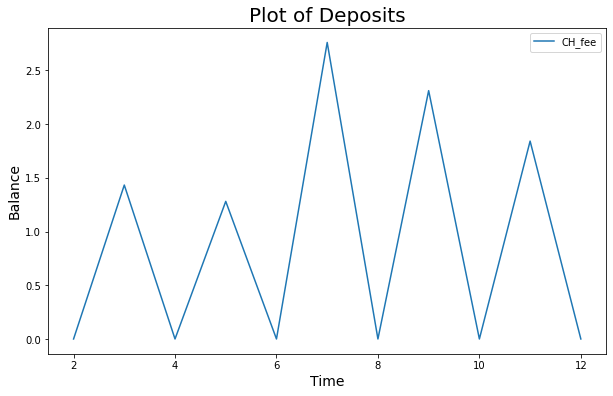

In [83]:
thesis_data_plot = thesis_data
thesis_data_plot["CH_fee"] = thesis_data_plot["clearing_house_fee_total"].diff()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(thesis_data_plot.index, thesis_data_plot['CH_fee'])
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['CH_fee'])
plt.title("Plot of Deposits", size=20)

fig.savefig('figures/Deposit_Payments.png')

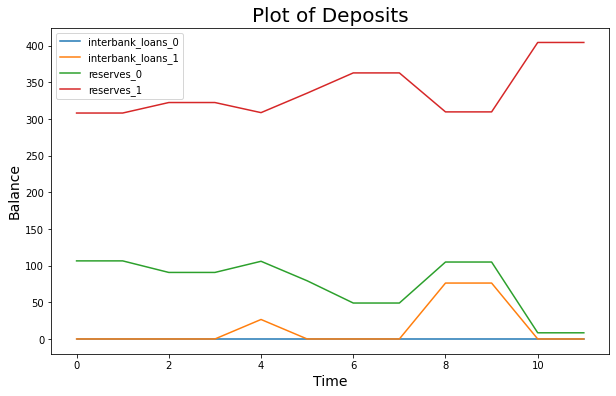

In [68]:
num_sim = int(parameter_values[0][1])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Bank
file_in = str('measurements/bank_output.json')
df = json.load(open(file_in))
bank_deposits = json_to_dataframe_account(df, num_sim, "interbank_loans")
bank_reserves = json_to_dataframe_account(df, num_sim, "reserves")

ax.plot(bank_deposits.index, bank_deposits)
ax.plot(bank_deposits.index, bank_reserves)
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['interbank_loans_0', 'interbank_loans_1', 'reserves_0', 'reserves_1'])
plt.title("Plot of Deposits", size=20)

fig.savefig('figures/Deposit_Payments.png')

{'bank_0': {'assets': {'interbank_loans': 0.0,
   'loans': 3815.638597666667,
   'reserves': 86.5608126429047,
   'bank_notes': 0.0,
   'open_market_operations': 10142.715149,
   'ach_payee_bank_0': 0.0},
  'liabilities': {'deposits': 4328.040632145235,
   'receivables': -3.1530333899354446e-14,
   'loans_central_bank': 0.47865033811862645,
   'ach_payer_bank_0': 0.0,
   'loans_interbank_bank_0': 90.52863134621441,
   'equity': 9625.866645480004}}}

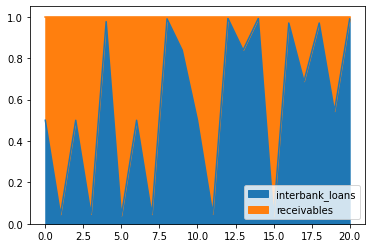

In [ ]:
df_bank_plot = df_bank[['interbank_loans', 'receivables']] + 1
df_bank_plot = df_bank_plot.divide(int(parameter_values[4][1]))
df_bank_plot.divide(df_bank_plot.sum(1), 0).plot.area()
environment.banks[0].balance_sheet()


<AxesSubplot:>

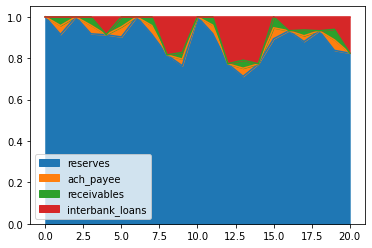

In [ ]:
df_bank_plot = df_bank[['reserves', 'ach_payee', 'receivables', 'interbank_loans']] + 0.1
df_bank_plot = df_bank_plot.divide(int(parameter_values[4][1]))
df_bank_plot.divide(df_bank_plot.sum(1), 0).plot.area()

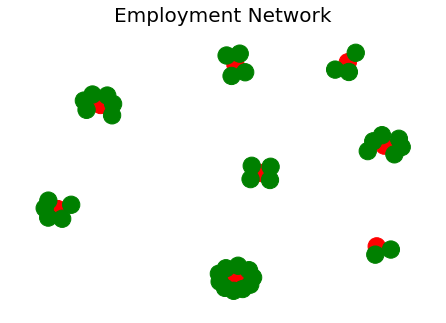

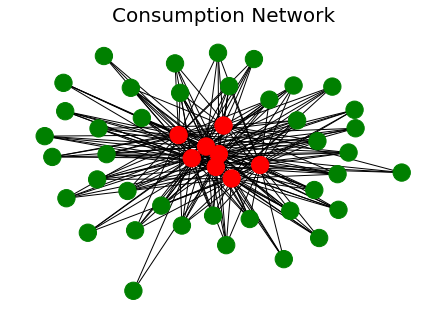

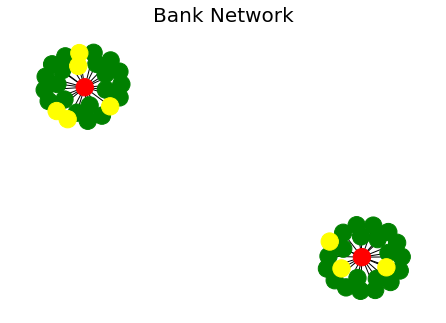

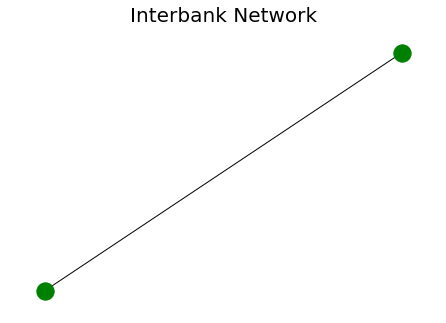

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
# Plot employment network    
E = environment.employment_network
color_map_E = ['red' if "firm" in node else 'green' for node in E]        
nx.draw(E, node_color=color_map_E)
plt.title("Employment Network", size=20)
plt.savefig('figures/employment_network.png')
plt.show()
# Plot consumption network
C = environment.consumption_network
color_map_C = ['red' if "firm" in node else 'green' for node in C]        
nx.draw(C, node_color=color_map_C)
plt.title("Consumption Network", size=20)
plt.savefig('figures/consumption_network.png')
plt.show()
# Plot bank network
B = environment.bank_network
color_map_B = ['red' if "bank" in node else 'yellow' if "firm" in node else 'green' for node in B]        
nx.draw(B, node_color=color_map_B)
plt.title("Bank Network", size=20)
plt.savefig('figures/bank_network.png')
plt.show()
# Plot interbank network
I = environment.interbank_network    
nx.draw(I, node_color="g")
plt.title("Interbank Network", size=20)
plt.savefig('figures/interbank_network.png')
plt.show()


In [ ]:
# hh = environment.households[0]
# hh_bank_acc = environment.bank_network.adj[hh.identifier]
# firm = environment.firms[0]
# firm_bank_acc = environment.bank_network.adj[firm.identifier]
# time = 1
# k = 100
# print(hh.identifier)
# print(firm.identifier)
# consumption_demand = {"type_": "deposit", "from_" : hh.identifier, "to" : firm.identifier, "amount" : k, "bank_from":hh_bank_acc, "bank_to":firm_bank_acc, "time" : time}
# environment.new_transaction(type_="deposits", asset='', from_= consumption_demand["from_"], to = consumption_demand["to"], amount = consumption_demand["amount"], interest=0.05, maturity=0, time_of_default=-1)